In [162]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [163]:
senate_polls_url = 'https://projects.fivethirtyeight.com/polls/data/senate_polls_historical.csv'
df = pd.read_csv(senate_polls_url)
df.to_csv("../Data/raw/senate_polls_historical.csv")

In [164]:
df = pd.read_csv("../Data/raw/senate_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

In [165]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [166]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [167]:
df.election_date.value_counts()

election_date
11/3/20     2375
11/8/22     2055
11/6/18     1992
1/5/21       182
12/6/22       28
11/27/18      24
Name: count, dtype: int64

In [168]:
df = df.query("stage == 'general'")
df = df.query("election_date == '11/8/22'")

In [169]:
df['date'] = df.median_date

df['week'] = (df['date'] - pd.Timestamp('2022-11-08')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2022-11-08')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [170]:
df[['state','party','answer','pct']].query("state == 'OH'").head(10)

,state,party,answer,pct
date,,,,
2022-11-06,OH,DEM,Ryan,46.0
2022-11-06,OH,REP,Vance,51.0
2022-11-05,OH,DEM,Ryan,46.0
2022-11-05,OH,REP,Vance,54.0
2022-11-04,OH,DEM,Ryan,43.0
2022-11-04,OH,REP,Vance,44.0
2022-11-04,OH,DEM,Ryan,45.0
2022-11-04,OH,REP,Vance,52.0
2022-11-04,OH,DEM,Ryan,43.5


In [171]:
#ALASKA - Lisa Murkowski	Kelly Tshibaka, Murkowski is D but caucuses with R
# Utah - Evan McMullin	
# OK & OK-S, OK-S: Markwayne Mullin	& Kendra Horn

#Seperate Oklahoma's special election
df.loc[(df['state'] == 'OK') & (df['answer'].isin(['Mullin', 'K. Horn'])),'state'] = 'OK-S'

#Make independents 'Democrats'
df.loc[(df['state'] == 'AK') & (df['answer'] == 'Murkowski'), 'party'] = 'DEM' #Note Murkowski is a Rep
df.loc[(df['state'] == 'UT') & (df['answer'] == 'McMullin'), 'party'] = 'DEM'

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df = df[df['party'] != 'OTH']

In [173]:
senate_races = {
'OK-S': ['M. Horn', 'Lankford'],
'AL': ['Boyd', 'Britt'],
'AK': ['Murkowski', 'Tshibaka'],
'AZ': ['Kelly', 'Masters'],
'AR': ['James', 'Boozman'],
'CA': ['Padilla', 'Meuser'],
'CO': ['Bennet', "O'Dea"],
'CT': ['Blumenthal', 'Levy'],
'FL': ['Demings', 'Rubio'],
'GA': ['Warnock', 'Walker'],
'HI': ['Schatz', 'McDermott'],
'ID': ['Roth', 'Crapo'],
'IL': ['Duckworth', 'Salvi'],
'IN': ['McDermott', 'Young'],
'IA': ['Franken', 'Grassley'],
'KS': ['Holland', 'Moran'],
'KY': ['Booker', 'Paul'],
'LA': ['Chambers', 'Kennedy'],
'MD': ['Van Hollen', 'Chaffee'],
'MO': ['Busch Valentine', 'Schmitt'],
'NV': ['Cortez Masto', 'Laxalt'],
'NH': ['Hassan', 'Bolduc'],
'NY': ['Schumer', 'Pinion'],
'NC': ['Beasley', 'Budd'],
'ND': ['Christiansen', 'Hoeven'],
'OH': ['Ryan', 'Vance'],
'OK': ['M. Horn', 'Lankford'],
'OR': ['Wyden', 'Perkins'],
'PA': ['Fetterman', 'Oz'],
'SC': ['Matthews', 'Scott'],
'SD': ['Bengs', 'Thune'],
'UT': ['McMullin', 'Lee'],
'VT': ['Welch', 'Malloy'],
'WA': ['Murray', 'Smiley'],
'WI': ['Barnes', 'Johnson'],
}

df = df.loc[df.apply(lambda row: row['answer'] in senate_races.get(row['state'], []), axis=1)]

In [174]:
df_count = df.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df2 = df_polls.merge(df_count)
df2 = df2.rename(columns={'REP':'GOP'})

df2[['DEM', 'GOP']] = df2[['DEM', 'GOP']].div(100)

In [175]:
df = df2
df = df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/1088463050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['obs_id'] = range(len(df))
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/1088463050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OTHER'] = 1 - (df['DEM'] + df['GOP'])


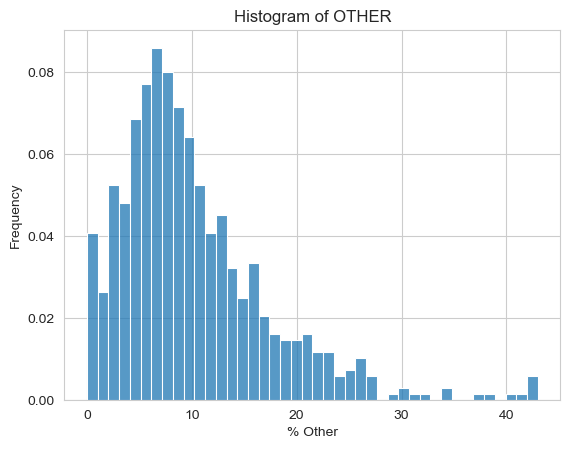

In [176]:
bin_width = 1
max_value = (100 * df['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Histogram of OTHER')
plt.show()

In [177]:
df = df.query("OTHER > 0")

In [178]:
df[['DEM', 'GOP']].describe()

,DEM,GOP
count,664.000000,664.000000
mean,0.452048,0.441895
std,0.061533,0.056941
min,0.190000,0.230000
25%,0.430000,0.410000
50%,0.460000,0.450000
75%,0.490000,0.480000
max,0.630000,0.615000


In [179]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(20).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

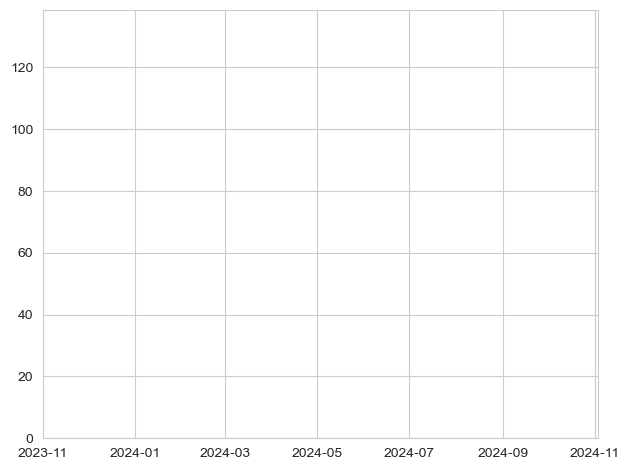

In [180]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2023, 11, 1), dt.datetime(2024, 11, 3))

plt.tight_layout()
plt.show()

In [181]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,IVR/Online Panel/Text-to-Web,IVR/Live Phone/Text/Online Panel/Email,Live Phone/Text-to-Web,IVR/Text,Online Panel/Text-to-Web,Online Panel/Online Ad,Text,Live Phone/Online Panel
pollster,,,,,,,,,,,
All,664,148,134,43,40,36,26,20,20,19,16
Center Street PAC,52,52,0,0,0,0,0,0,0,0,0
Emerson,47,0,0,24,0,0,0,0,0,0,0
Trafalgar Group,39,0,0,0,39,0,0,0,0,0,0
Data for Progress,27,0,0,0,0,0,0,18,0,0,0
Cygnal,24,0,0,12,0,6,0,0,0,0,0
InsiderAdvantage,19,0,0,0,0,0,0,0,0,17,0
Civiqs,18,0,0,0,0,0,0,0,18,0,0
SurveyUSA,16,16,0,0,0,0,0,0,0,0,0


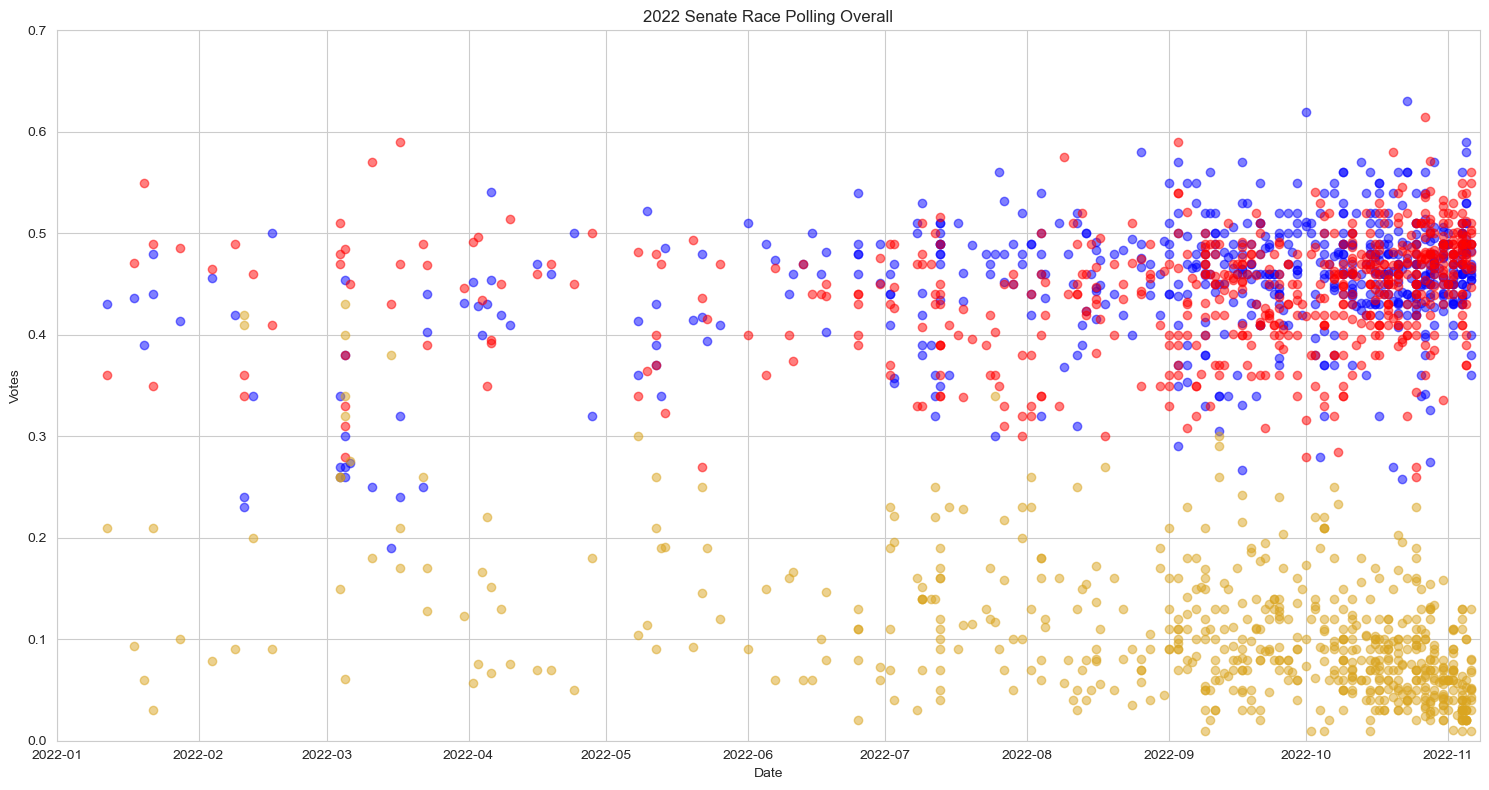

In [188]:
dem_votes = df["DEM"].values
gop_votes = df["GOP"].values
oth_votes = df["OTHER"].values

dates = df.set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.5, color='blue', label="Democrat")
ax.plot(dates, gop_votes, "o", alpha=0.5, color='red', label="Republican")
ax.plot(dates, oth_votes, "o", alpha=0.5, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.7)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2022 Senate Race Polling Overall')

plt.tight_layout()
plt.show()

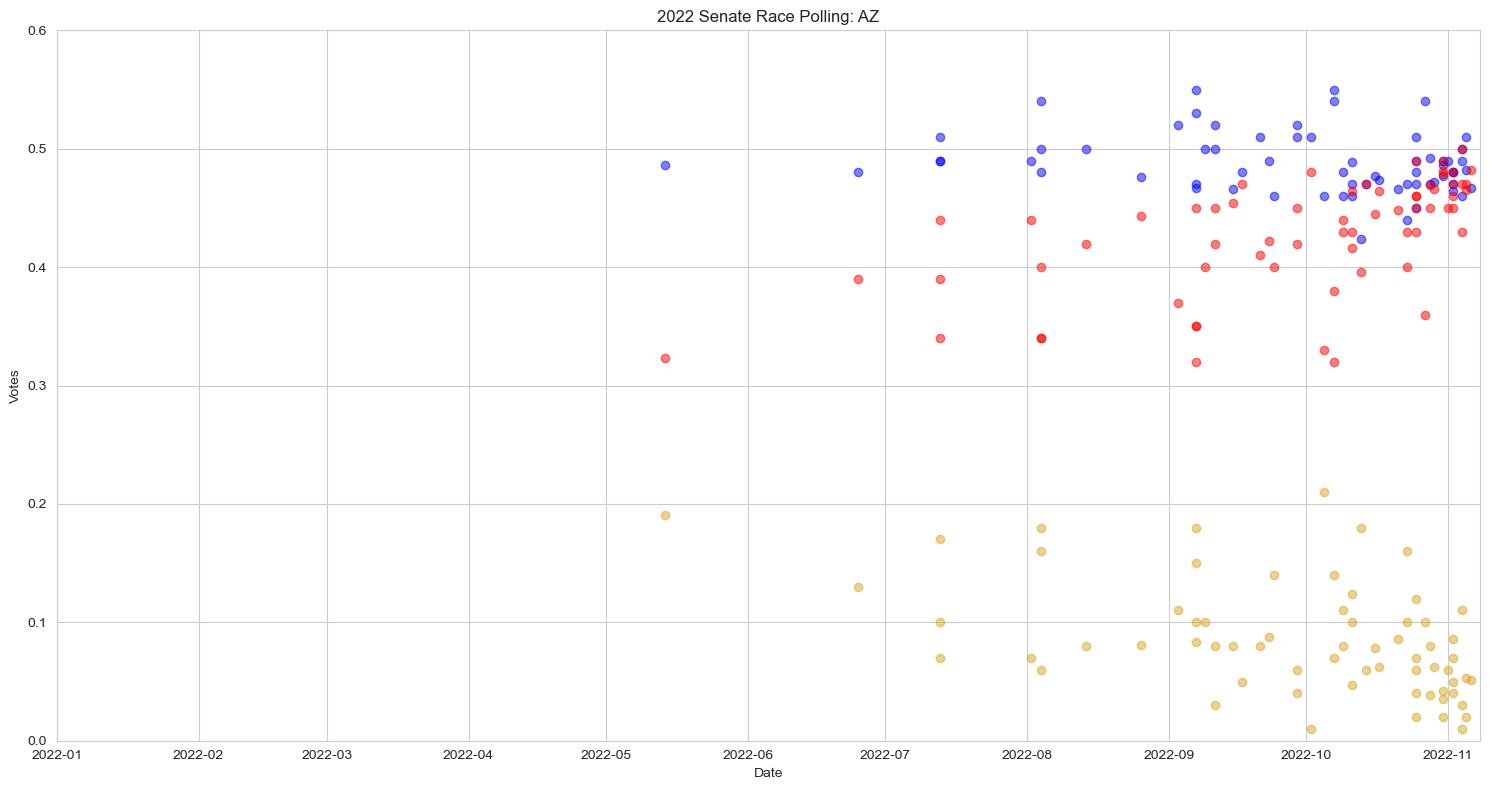

In [189]:
graph_state = 'AZ'

dem_votes = df.query(f"state == '{graph_state}'")["DEM"].values
gop_votes = df.query(f"state == '{graph_state}'")["GOP"].values
oth_votes = df.query(f"state == '{graph_state}'")["OTHER"].values

dates = df.query(f"state == '{graph_state}'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.5, color='blue', label="Democrat")
ax.plot(dates, gop_votes, "o", alpha=0.5, color='red', label="Republican")
ax.plot(dates, oth_votes, "o", alpha=0.5, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f"2022 Senate Race Polling: {graph_state}")

events = [
            (dt.datetime(2022, 11, 8), 'Election Day')
         ]

plt.tight_layout()
plt.show()

Text(0.5, 1.0, '30-Day Rolling Polling Mean: AZ')

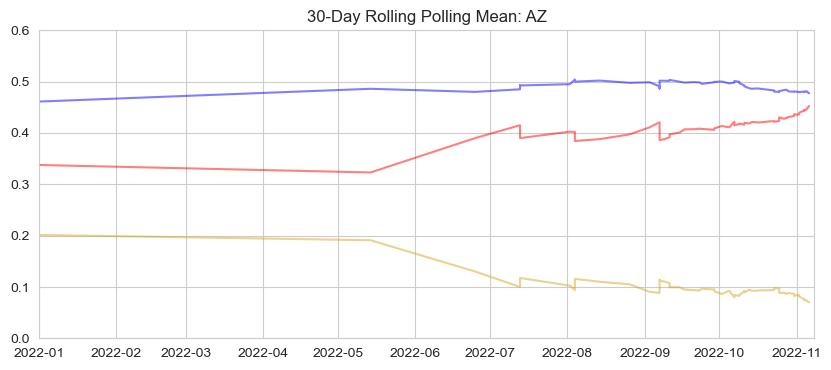

In [190]:
graph_state = 'AZ'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title(f"30-Day Rolling Polling Mean: {graph_state}")

Text(0.5, 1.0, '30-Day Rolling Polling Standard Deviation: AZ')

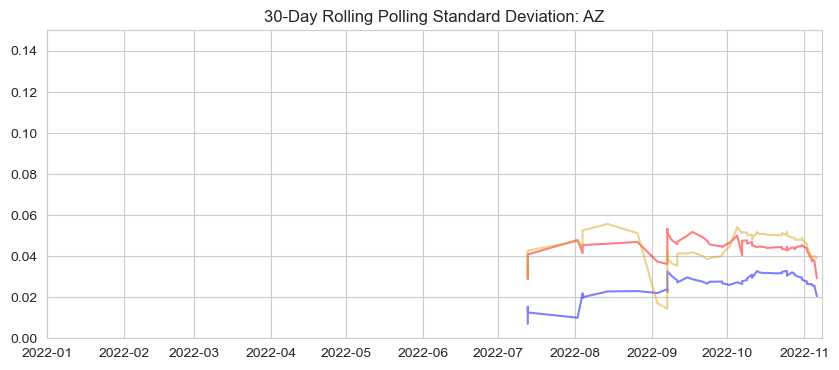

In [191]:
graph_state = 'AZ'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()  # Sort the date index to ensure it's monotonic
    .rolling(window='30D')
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .15)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title(f"30-Day Rolling Polling Standard Deviation: {graph_state}")

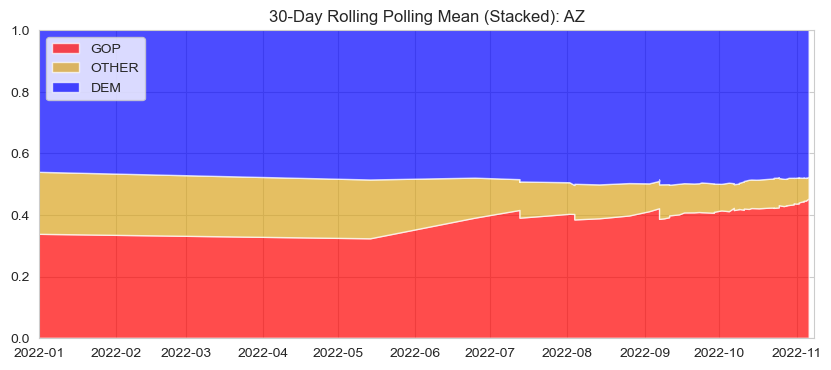

In [192]:
graph_state = 'AZ'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "GOP", "OTHER", "DEM"]]
    .set_index("date")
    .sort_index()  # Ensure the index is sorted
    .rolling(window='30D')
    .mean()
    .reset_index()[["date", "GOP", "OTHER", "DEM"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    rolling_mean.OTHER.values,
    rolling_mean.DEM.values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title(f"30-Day Rolling Polling Mean (Stacked): {graph_state}")
ax.legend(loc='upper left')

plt.show()

In [193]:
df.query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.431667,0.465333
IVR/Text,0.467346,0.424231
Live Phone,0.441701,0.443634
Live Phone/Online Panel,0.450313,0.447625
Online Panel,0.441589,0.414540
Probability Panel,0.511429,0.407143
Text-to-Web/Online Ad,0.434286,0.445714


In [194]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [195]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,field_date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,GOP,obs_id,OTHER,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,0,81629,165305,1250,Trafalgar Group,IVR/Live Phone/Text/Online Panel/Email,AZ,lv,1094.0,2022,...,0.48,0,0.05,-0.02,0.48,0.47,-0.01,0.00,-0.00,-0.01
1,1,81775,166099,1250,Trafalgar Group,IVR/Live Phone/Text/Online Panel/Email,NV,lv,1089.0,2022,...,0.50,1,0.04,-0.05,0.48,0.47,-0.01,0.03,-0.01,-0.04
2,2,81778,166100,1528,AtlasIntel,Online Ad,GA,a,905.0,2022,...,0.46,2,0.08,-0.01,0.48,0.47,-0.01,-0.01,-0.01,-0.00
3,3,81778,166101,1528,AtlasIntel,Online Ad,GA,lv,791.0,2022,...,0.49,3,0.05,-0.03,0.48,0.47,-0.01,0.01,-0.01,-0.02
4,6,81579,165126,262,Landmark Communications,Live Phone/Online Panel,GA,lv,1214.0,2022,...,0.47,6,0.07,-0.00,0.48,0.47,-0.01,-0.01,-0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,765,74872,142653,383,PPP,IVR/Text,WA,lv,992.0,2022,...,0.37,681,0.10,0.16,0.37,0.53,0.16,0.00,0.00,0.00
660,766,74899,142708,1365,Change Research,Text-to-Web/Online Ad,AK,lv,1023.0,2022,...,0.39,682,0.42,-0.20,0.39,0.19,-0.20,0.00,0.00,0.00
661,785,74544,140305,383,PPP,IVR/Text,OH,v,700.0,2022,...,0.39,683,0.24,-0.02,0.39,0.37,-0.02,0.00,0.00,0.00
662,787,74487,140160,1671,Trafalgar Group/InsiderAdvantage,IVR/Live Phone/Text/Online Panel/Email,GA,lv,1093.0,2022,...,0.48,684,0.07,-0.02,0.48,0.46,-0.02,0.00,0.00,0.00


In [196]:
df[['margin']].mean()

margin    0.010153
dtype: float64

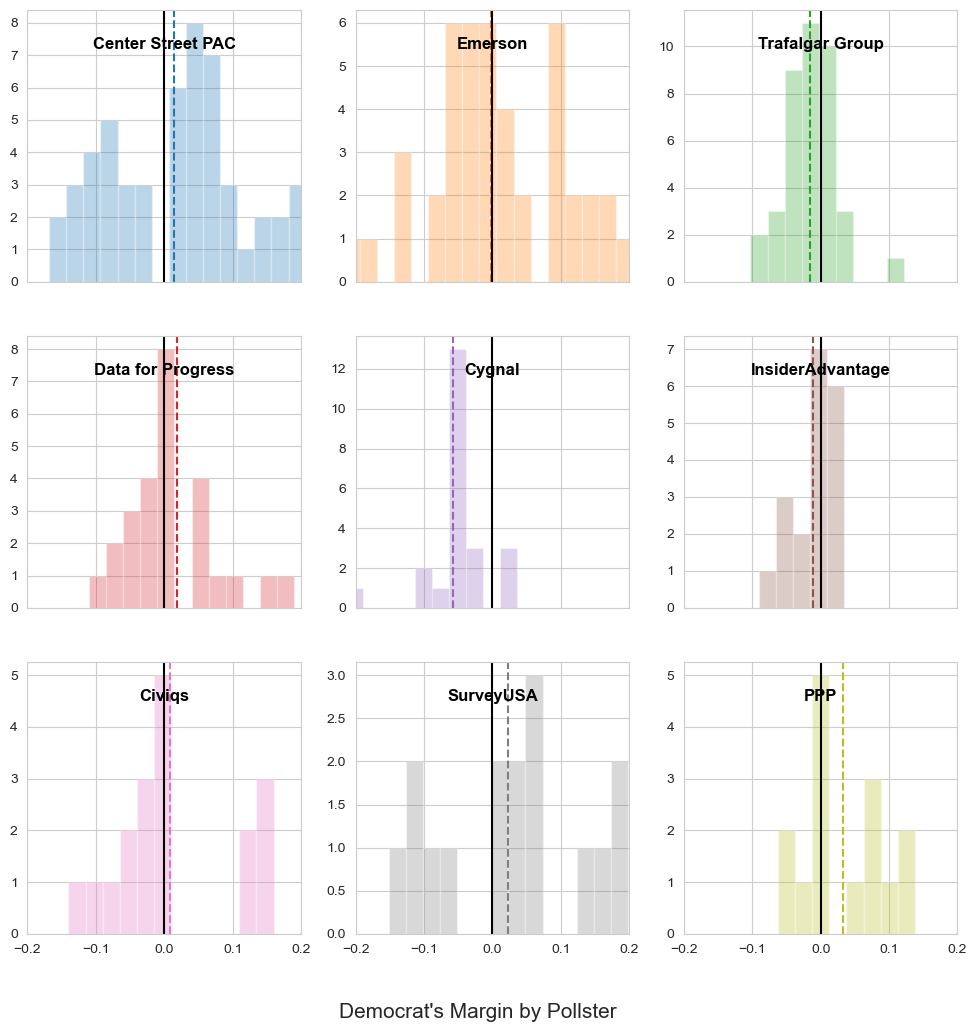

In [197]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.2, .2)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

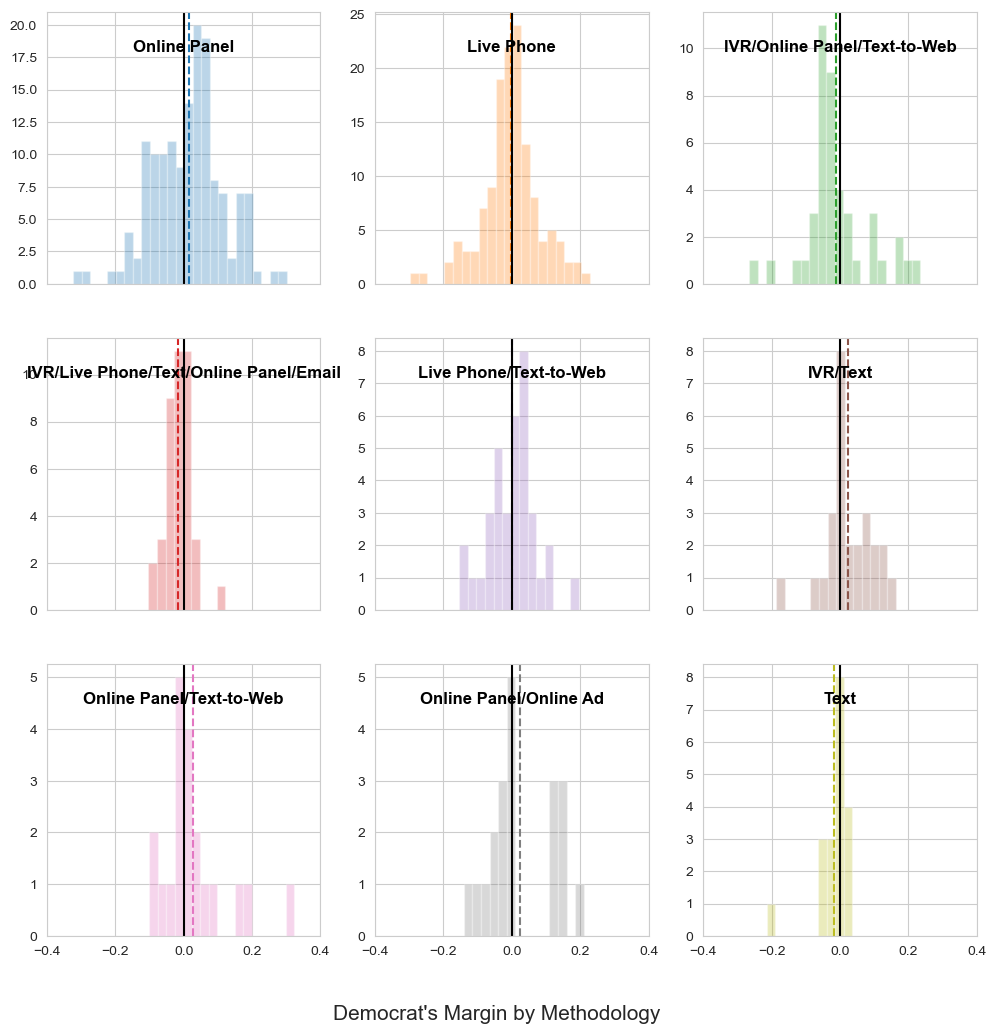

In [198]:
METHOD_VALS = {
    method: df[df["methodology"] == method]["diff_margin"].values
    for method in list(METHODS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), METHOD_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.4, .4)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Methodology", ha='center', fontsize=15)

# Show the plot
plt.show()

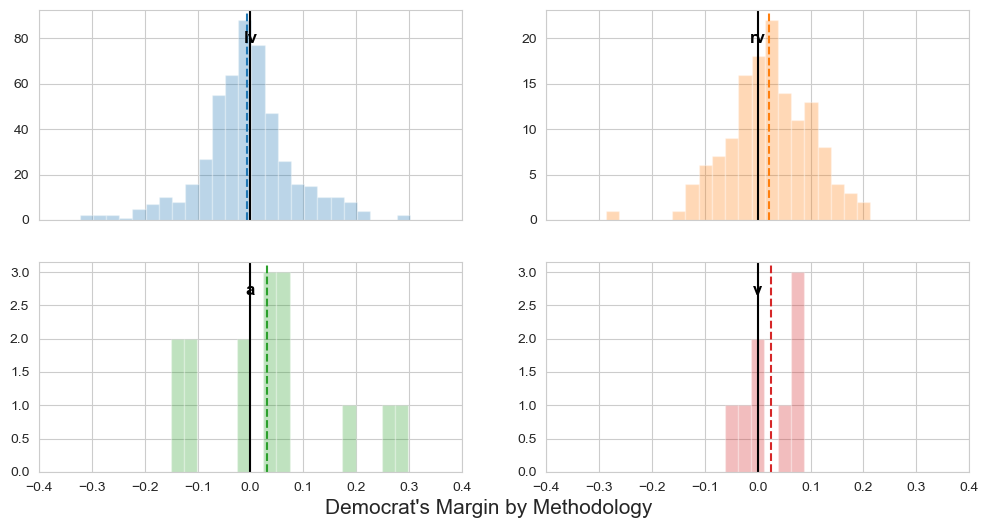

In [199]:
POPULATIONS_VALS = {
    population: df[df["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(12, 6))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.4, .4)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Methodology", ha='center', fontsize=15)

# Show the plot
plt.show()

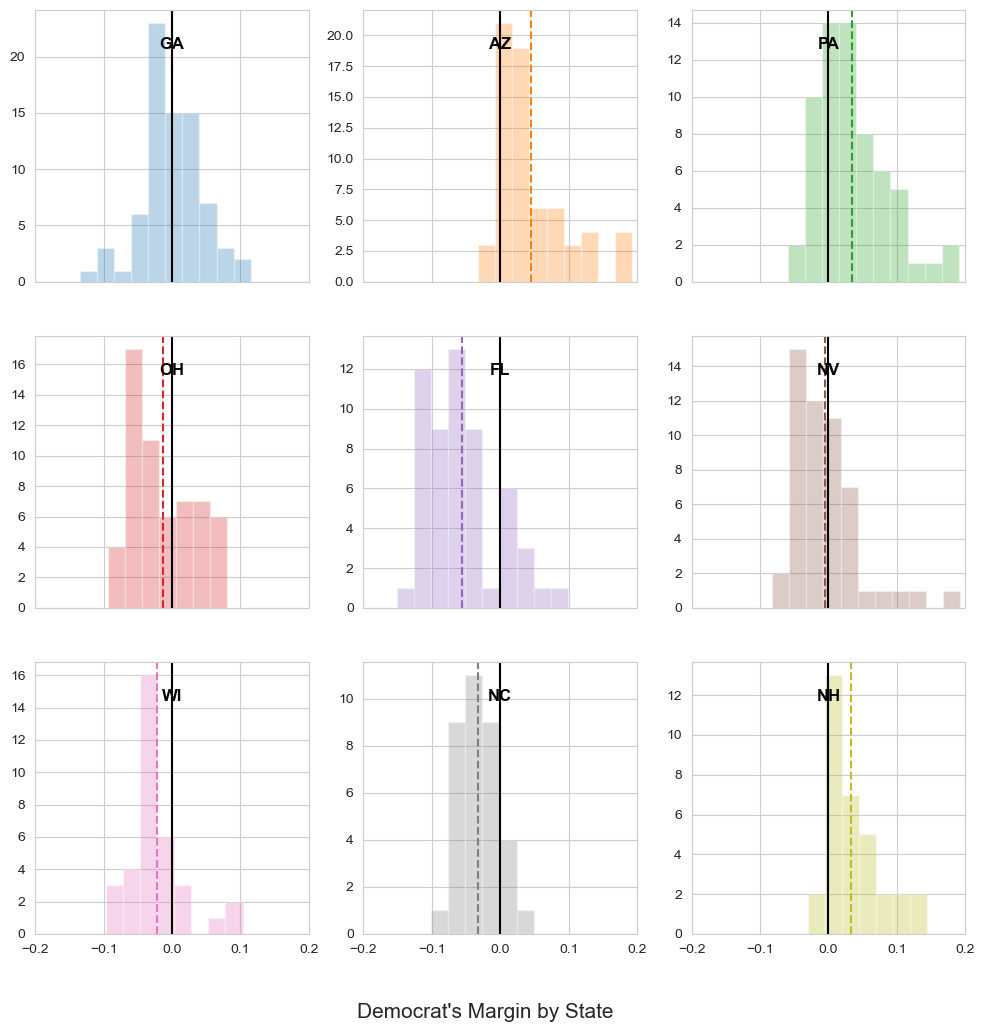

In [200]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (state, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    bin_width = 0.025
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.2, .2)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, state, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by State", ha='center', fontsize=15)

# Show the plot
plt.show()

In [201]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

#day_id, day = df.set_index(["day"]).index.factorize(sort=True)
day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [202]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_fund_dem = pm.Normal("polling_error_fund_dem", 0, .022)
    polling_error_fund_gop = pm.Deterministic("polling_error_fund_gop", -polling_error_fund_dem)
    polling_error_fund_oth = pm.Deterministic("polling_error_fund_oth", polling_error_fund_dem*0)

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, .030, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_fund_dem, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 880 seconds.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


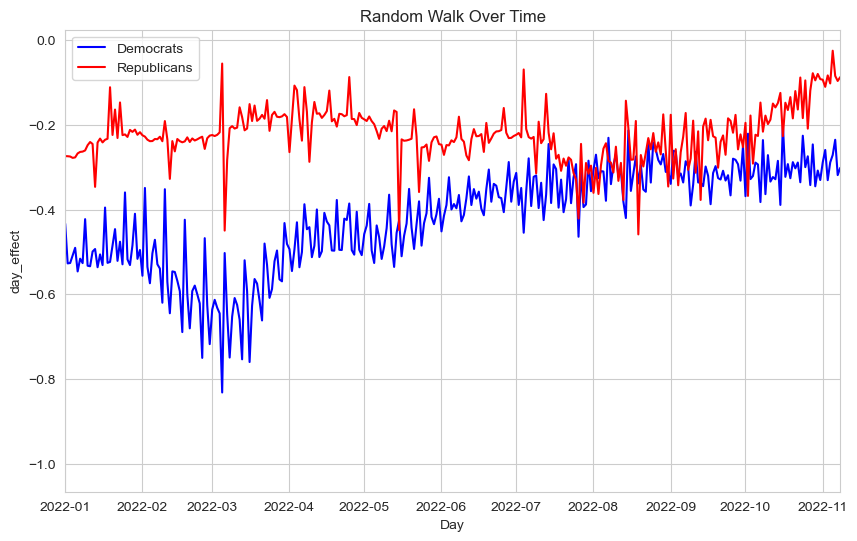

In [316]:
rw = pd.DataFrame()
rw['day'] = pd.date_range(start=df.date.min(), end='2022-11-08')
rw['dem'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values
rw['gop'] = idata.posterior.gop_day_effect.mean(axis=0).mean(axis=0).values
rw = rw.set_index('day')

# Creating the figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
ax.plot(rw['dem'], color='blue', label='Democrats', linestyle='-')
ax.plot(rw['gop'], color='red', label='Republicans', linestyle='-')

# Setting labels, title, and grid
ax.set_xlabel('Day')
ax.set_ylabel('day_effect')
ax.set_title('Random Walk Over Time')
ax.grid(True)

ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))

# Adding a legend
ax.legend()

# Showing the plot
plt.show()

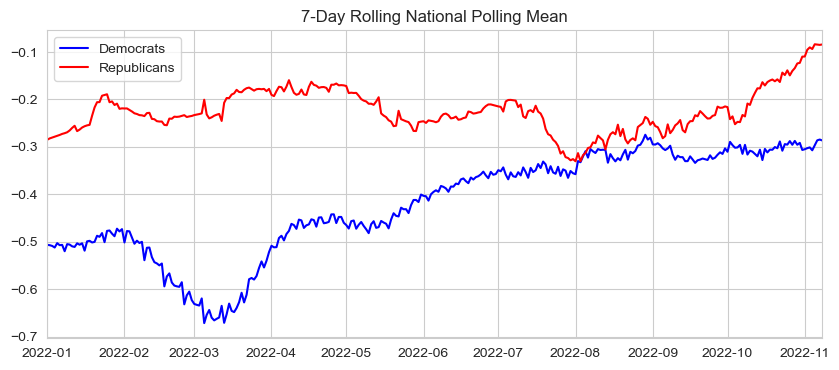

In [317]:
rolling_mean = (
    rw[["gop", "dem"]]
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["day","gop", "dem"]]
    .dropna()
).set_index('day')

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(rolling_mean['dem'], color='blue', label='Democrats', linestyle='-')
ax.plot(rolling_mean['gop'], color='red', label='Republicans', linestyle='-')

ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title("7-Day Rolling National Polling Mean")
ax.legend(loc='upper left')

plt.show()

In [318]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [319]:
df['state'].unique()

array(['AZ', 'NV', 'GA', 'WI', 'OH', 'IN', 'MO', 'CO', 'NH', 'OK', 'NC',
       'CA', 'FL', 'IL', 'NY', 'PA', 'OR', 'WA', 'IA', 'AR', 'UT', 'AL',
       'KS', 'CT', 'VT', 'AK', 'SD', 'MD', 'SC', 'KY'], dtype=object)

In [320]:
df.pollster.value_counts().head(10)

pollster
Center Street PAC    52
Emerson              47
Trafalgar Group      39
Data for Progress    27
Cygnal               24
InsiderAdvantage     19
Civiqs               18
SurveyUSA            16
PPP                  15
Suffolk              14
Name: count, dtype: int64

In [321]:
df.methodology.value_counts().head(10)

methodology
Online Panel                              148
Live Phone                                134
IVR/Online Panel/Text-to-Web               43
IVR/Live Phone/Text/Online Panel/Email     40
Live Phone/Text-to-Web                     36
IVR/Text                                   26
Online Panel/Online Ad                     20
Online Panel/Text-to-Web                   20
Text                                       19
Live Phone/Online Panel                    16
Name: count, dtype: int64

In [322]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson") #+
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Beacon/Shaw") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist")
    ).values #/ 2
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2)
        #+
        #idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2)
    )#/2
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"polling_error_{party}"] = idata.posterior[f"polling_error_fund_{party}"].values.ravel()

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"] + interim[f"polling_error_{party}"]

In [323]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-18]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            # Calculate the results and store them in the dictionary
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                #+ (.05 if party == 'gop' else 0) # 1% swing towards GOP
                #+ (.05 if party == 'dem' else 0) # 1% swing towards DEM
                )  
            ).to_numpy()

        # Adjust the 'oth' results and sum the total
        day_results[f"{state}_dem"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_gop"] += day_results[f"{state}_oth"] / 4
        day_results[f"{state}_oth"] /= 2

        # Calculate total votes and normalize
        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        # Calculate margin
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    # Convert day_results to DataFrame
    df_results = pd.DataFrame(day_results)

    # Store quantiles and mean for this day
    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 627/627 [00:35<00:00, 17.76it/s]


<Axes: >

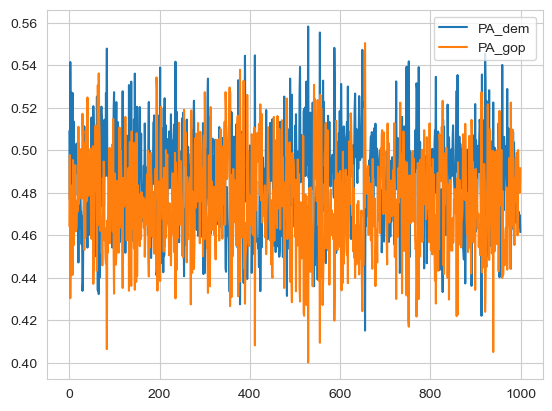

In [324]:
df_results[['PA_dem','PA_gop']].plot()

In [325]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2022-11-08')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [326]:
min(df_day_mean.index)

-626

In [327]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/4038335678.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/4038335678.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, 

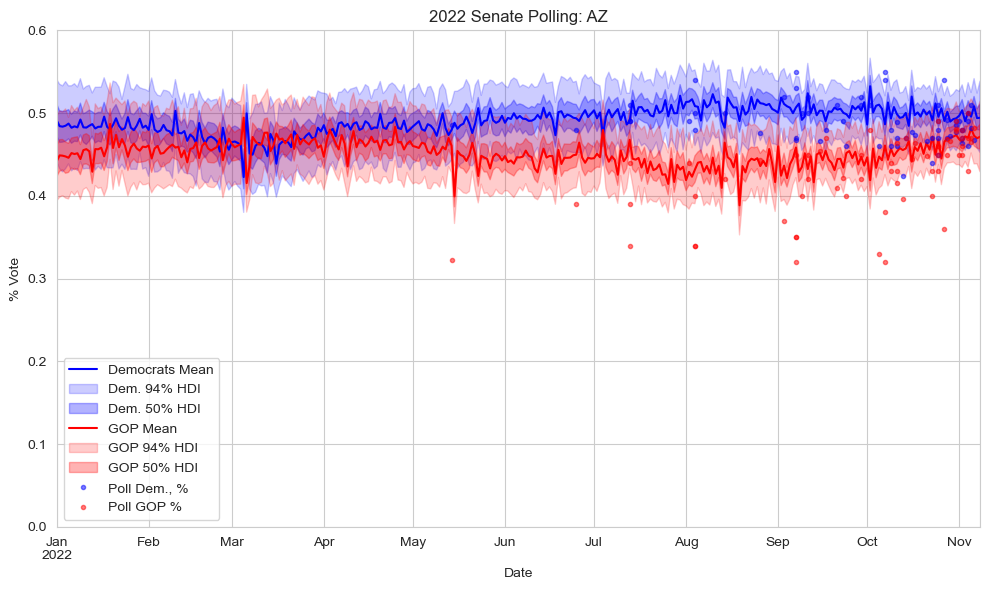

In [328]:
graph_state = 'AZ'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]

ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0,.6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
ax.set_title(f'2022 Senate Polling: {graph_state}')

plt.tight_layout()
plt.savefig(f"senate_{graph_state}.png")

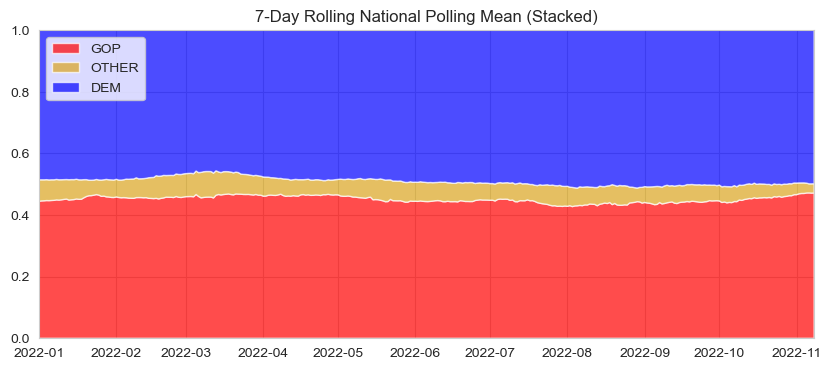

In [329]:
graph_state = 'AZ'

rolling_mean = (
    df_day_mean[[f"{graph_state}_gop", f"{graph_state}_dem"]]
    .sort_index()  # Ensure the index is sorted
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", f"{graph_state}_gop", f"{graph_state}_dem"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))

ax.stackplot(
    rolling_mean.date,
    rolling_mean[f"{graph_state}_gop"].values,
    (1-rolling_mean[f"{graph_state}_dem"].values-rolling_mean[f"{graph_state}_gop"].values),
    rolling_mean[f"{graph_state}_dem"].values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=0.7,
)

ax.set_ylim(0, 1)  # Adjusted to fit the stacked plot
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_title("7-Day Rolling National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.show()

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/2679725951.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03.filter(regex='_dem$').mean(axis=1).ffill(), df_day_97.filter(regex='_dem$').mean(axis=1).ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/2679725951.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03.filter(regex='_dem$').mean(axis=1).ffill(), df_day_97.filter(regex='_de

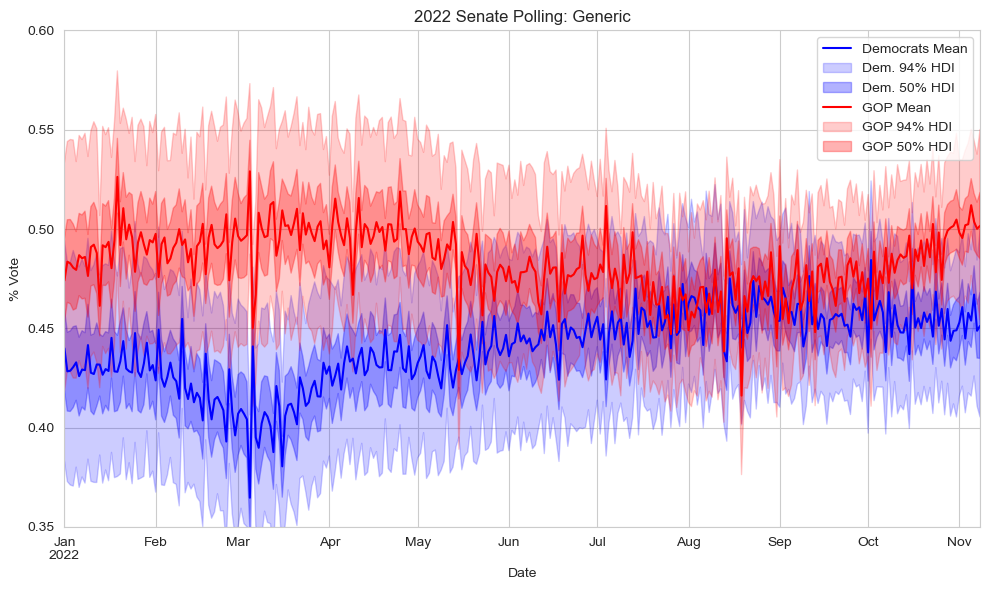

In [330]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean.filter(regex='_dem$').mean(axis=1).plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03.filter(regex='_dem$').mean(axis=1).ffill(), df_day_97.filter(regex='_dem$').mean(axis=1).ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25.filter(regex='_dem$').mean(axis=1).ffill(), df_day_75.filter(regex='_dem$').mean(axis=1).ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean.filter(regex='gop$').mean(axis=1).plot(color='red', label='GOP Mean')
plt.fill_between(df_day_97.index, df_day_03.filter(regex='gop$').mean(axis=1).ffill(), df_day_97.filter(regex='gop$').mean(axis=1).ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25.filter(regex='gop$').mean(axis=1).ffill(), df_day_75.filter(regex='gop$').mean(axis=1).ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

# Set limits and labels
ax.set_ylim(0.35,.6)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
ax.set_title(f'2022 Senate Polling: Generic')

plt.tight_layout()
plt.savefig(f"senate_generic.png")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/272734662.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_mean.index, np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=1, label='Mean HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/272734662.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_mean.index, np.maximum(df_day_mean.filter(regex='_margin$'

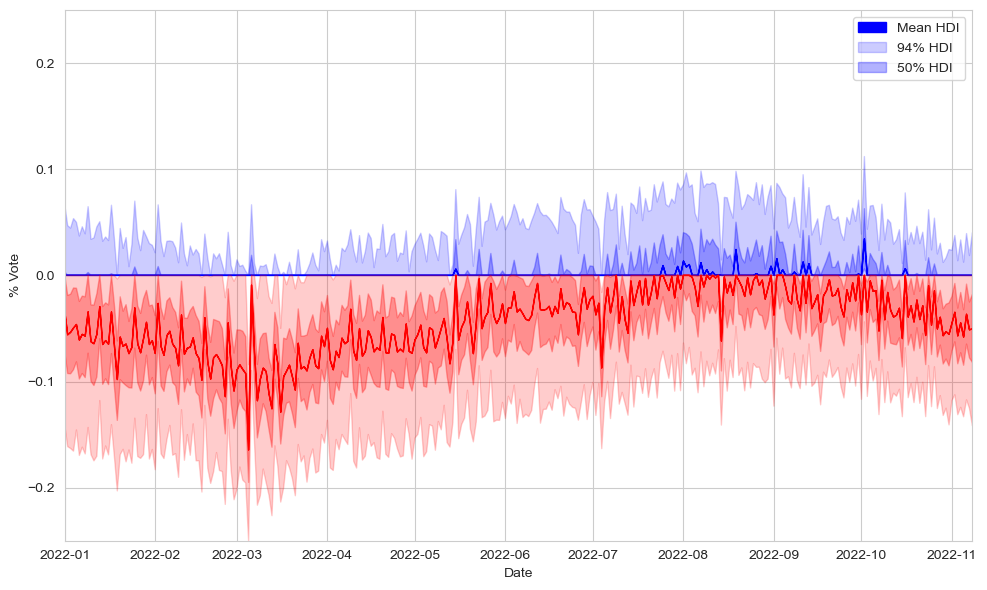

In [331]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

plt.fill_between(df_day_mean.index, np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=1, label='Mean HDI')
plt.fill_between(df_day_97.index, np.maximum(df_day_03.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_97.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=0.2, label='94% HDI')
plt.fill_between(df_day_75.index, np.maximum(df_day_25.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.maximum(df_day_75.filter(regex='_margin$').mean(axis=1).ffill(),0), color='blue', alpha=0.3, label='50% HDI')
plt.fill_between(df_day_mean.index, np.minimum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.minimum(df_day_mean.filter(regex='_margin$').mean(axis=1).ffill(),0), color='red', alpha=1)
plt.fill_between(df_day_97.index, np.minimum(df_day_03.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.minimum(df_day_97.filter(regex='_margin$').mean(axis=1).ffill(),0), color='red', alpha=0.2)
plt.fill_between(df_day_75.index, np.minimum(df_day_25.filter(regex='_margin$').mean(axis=1).ffill(), 0), np.minimum(df_day_75.filter(regex='_margin$').mean(axis=1).ffill(),0), color='red', alpha=0.3)

# Set limits and labels
ax.set_ylim(-0.25,0.25)
ax.set_xlim(dt.datetime(2022, 1, 1), dt.datetime(2022, 11, 8) #datetime.datetime.today()
           )
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

plt.tight_layout()
plt.savefig('past_three_years.png')

In [332]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [333]:
races = ['OK-S','AL','AK','AZ','AR','CA','CO','CT','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','MD','MO','NV','NH','NY','NC','ND','OH','OK','OR','PA','SC','SD','UT','VT','WA','WI']

pd.Series(races)[~pd.Series(races).isin(df['state'])]

0     OK-S
10      HI
11      ID
17      LA
24      ND
dtype: object

In [334]:
df_winner['OK-S'] = 'gop'
df_winner['HI'] = 'dem'
df_winner['ID'] = 'gop'
df_winner['LA'] = 'gop'
df_winner['ND'] = 'gop'

df_winner['AK'] = 'gop' #Alaska is both R

state_order = df_state['state_code'].to_list

In [335]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [336]:
df_senate = pd.DataFrame()
df_senate['dem'] = 34 + df_winner_dem.sum(axis=1)
df_senate['gop'] = 29 + df_winner_gop.sum(axis=1)
df_senate['dem_senate'] = np.where(df_senate['dem'] >= 51, 1, 0)
df_senate['gop_senate'] = np.where(df_senate['gop'] >= 51, 1, 0)
df_senate['tie_senate'] = np.where(df_senate['dem'] == 50, 1, 0)

In [337]:
# Calculate the total number of rows
total_rows = len(df_senate)

# Calculate the number of rows greater than, equal to, and lower than 50
greater_than_50 = len(df_senate[df_senate['dem'] > 50])
equal_to_50 = len(df_senate[df_senate['dem'] == 50])
lower_than_50 = len(df_senate[df_senate['dem'] < 50])

# Calculate the percentages
percent_greater_than_50 = (greater_than_50 / total_rows) * 100
percent_equal_to_50 = (equal_to_50 / total_rows) * 100
percent_lower_than_50 = (lower_than_50 / total_rows) * 100

percent_greater_than_50, percent_equal_to_50, percent_lower_than_50

(11.5, 5.2, 83.3)

In [338]:
df_senate[['dem','gop']].max()

dem    56
gop    61
dtype: int64

In [339]:
df_senate[['dem','gop']].min()

dem    37
gop    42
dtype: int64

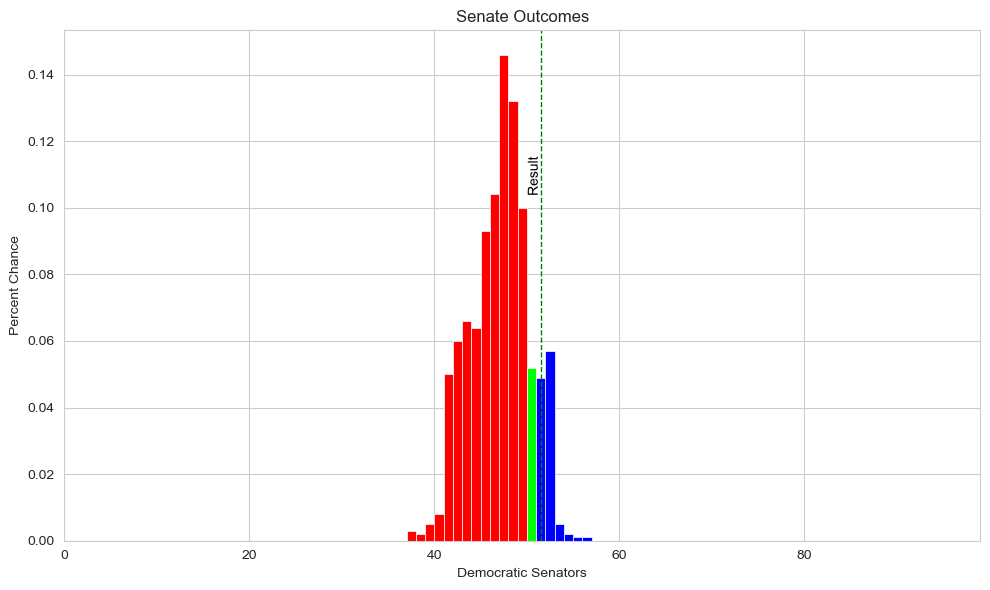

In [340]:
plt.figure(figsize=(10, 6))

bins = list(range(0, 50, 1)) + [50] + list(range(51, 100, 1))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_senate['dem'], bins=bins, kde=False, stat="probability")

# Get patches from the Axes
max_height = max([patch.get_height() for patch in ax.patches])

# Get the lowest and highest x values from the histogram bars
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() #+ 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 50:
        patch.set_facecolor('red')
    elif x > 50:
        patch.set_facecolor('blue')
    elif x == 50:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

# Adding titles and labels
plt.title('Senate Outcomes')
plt.xlabel('Democratic Senators')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (51.5, 'Result'),
]

label_position = 3/4 * max_height

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    text = plt.text(date, label_position, event, rotation=90, verticalalignment='center', 
                    horizontalalignment='right', fontsize=10, color='black')
    
    # Add white outline to the text
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                           path_effects.Normal()])

plt.tight_layout()
# Display the plot
plt.savefig('2way_enight_ec.png')

In [341]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [342]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [343]:
df_win_pct.sort_values('dem')

,dem,gop
ND,0.000,1.000
AL,0.000,1.000
AR,0.000,1.000
LA,0.000,1.000
SD,0.000,1.000
SC,0.000,1.000
KS,0.000,1.000
OK,0.000,1.000
AK,0.000,1.000
ID,0.000,1.000


In [344]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).mean()
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin['state_code'] = df_dem.columns.values

df_margin['electoral_2024'] = 10

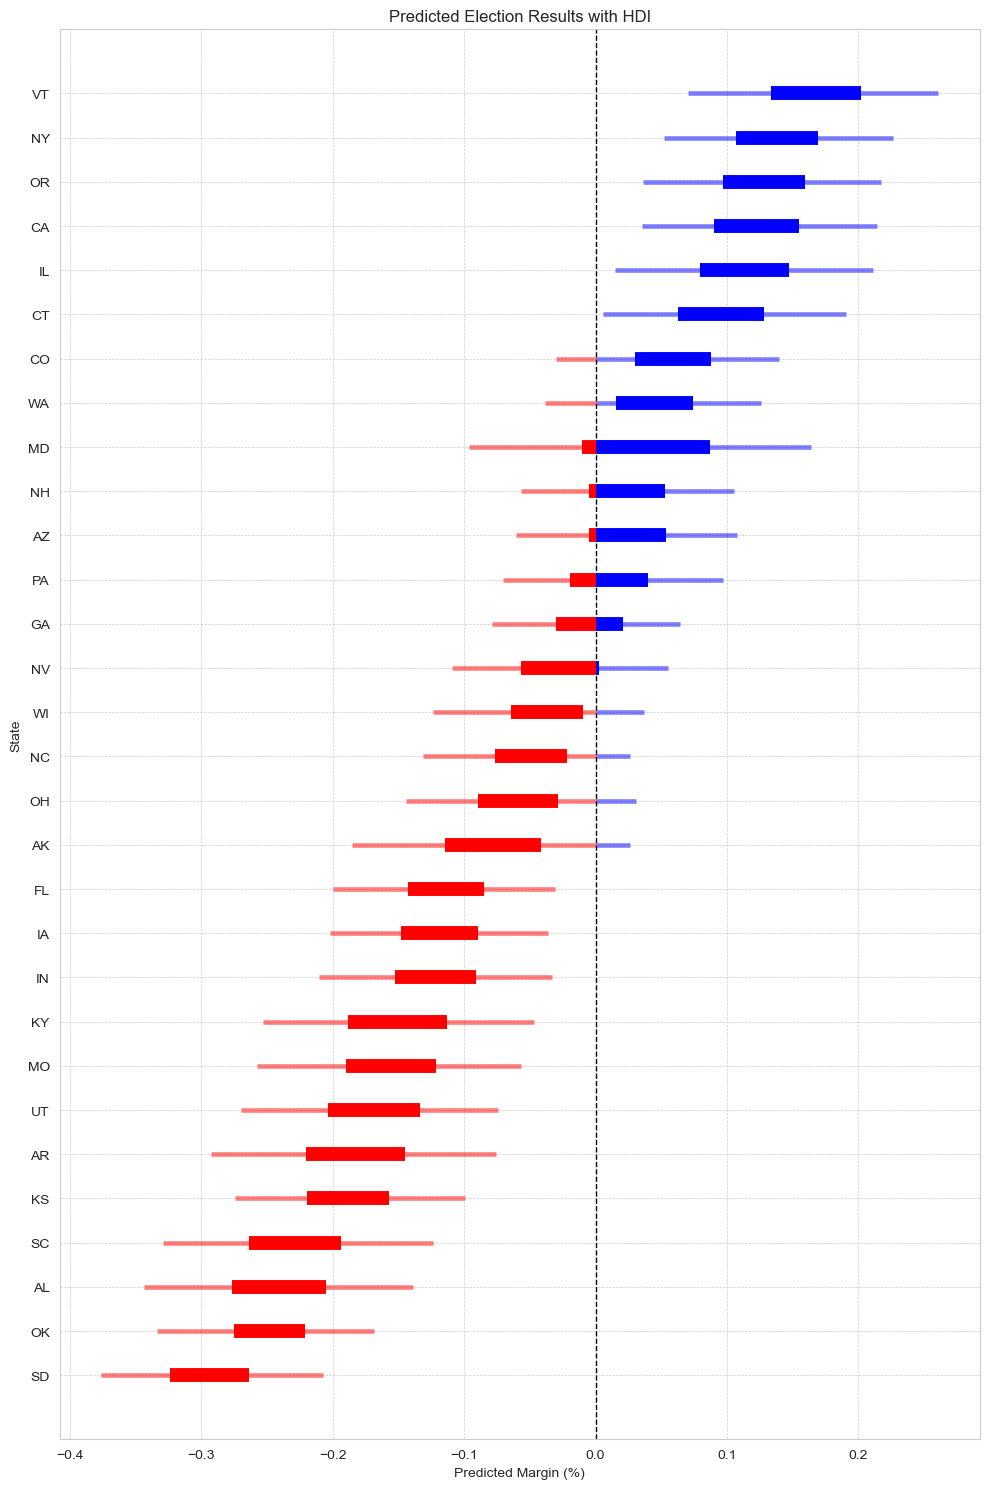

In [345]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(10, 15))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('all_states.png')

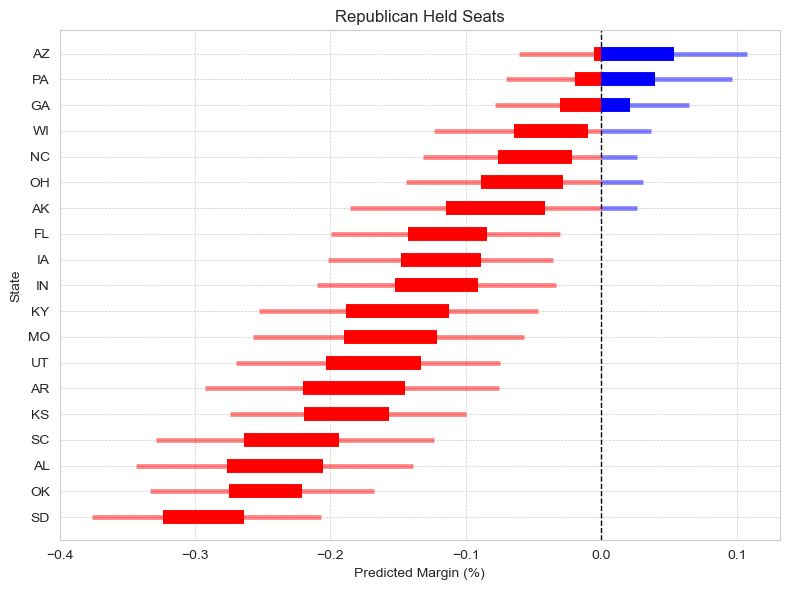

In [346]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('AL', 'AK', 'AZ', 'AR', 'FL', 'GA', 'ID', 'IN', 'IA', 'KS', 'KY', 'LA', 'MO', 'NE', 'NC', 'ND', 'OH', 'OK', 'OK-S', 'PA', 'SC', 'SD', 'UT', 'WI')").sort_values(by='hdi_mean')
scale_factor = 1

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(8, 6))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Republican Held Seats')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('center_race.png')

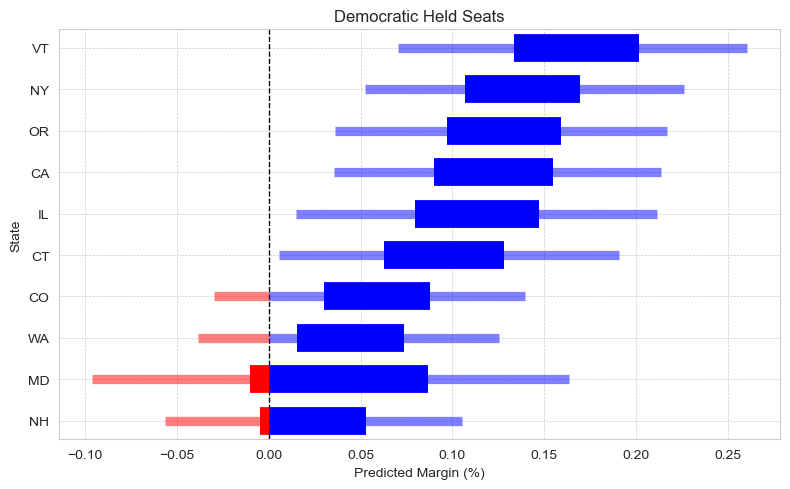

In [347]:
# Sort the dataframe by the absolute value of 'hdi_mean'
chart_df = df_margin.query("state_code in ('CA', 'CO', 'CT', 'HI', 'IL', 'MD', 'NH', 'NY', 'OR', 'VT', 'WA')").sort_values(by='hdi_mean')
scale_factor = 2

# Create custom y-axis positions based on cumulative electoral votes
cumulative_votes = np.cumsum(chart_df['electoral_2024'] * scale_factor)
y_positions = cumulative_votes - (chart_df['electoral_2024'] * scale_factor / 2)

# Set up the figure
plt.figure(figsize=(8, 5))

# Plot each segment of the 50% HDI interval
for i, row in chart_df.iterrows():
    # If hdi_75 is above 0, split the interval at 0
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['electoral_2024'] * scale_factor, zorder=3)
    # If hdi_97 is above 0, split the interval at 0
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is above 0
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)
    # If the entire interval is below 0
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['electoral_2024'] * scale_factor / 3, zorder=3)

# Add a vertical line at zero for reference
plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

# Set the y-axis labels to the state codes
plt.yticks(y_positions, chart_df['state_code'])

# Labels and title
plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Democratic Held Seats')

# Improve grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()

# Display the plot
plt.savefig('center_race.png')

In [348]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_senate[['dem_senate','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['generic_margin'] = df_dem.mean(axis=1) - df_gop.mean(axis=1)

grouped_df = df_winp.groupby(list(df_winp.columns[1:-1])).agg(
    count=('generic_margin', 'size'),   # Count the occurrences of each unique combination of rows
    generic_margin=('generic_margin', 'mean')  # Calculate the mean of the 'margin' column
).reset_index().sort_values("count", ascending = False)
grouped_df.to_excel('df_value_counts.xlsx', index=False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/2984995915.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_40513/2984995915.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


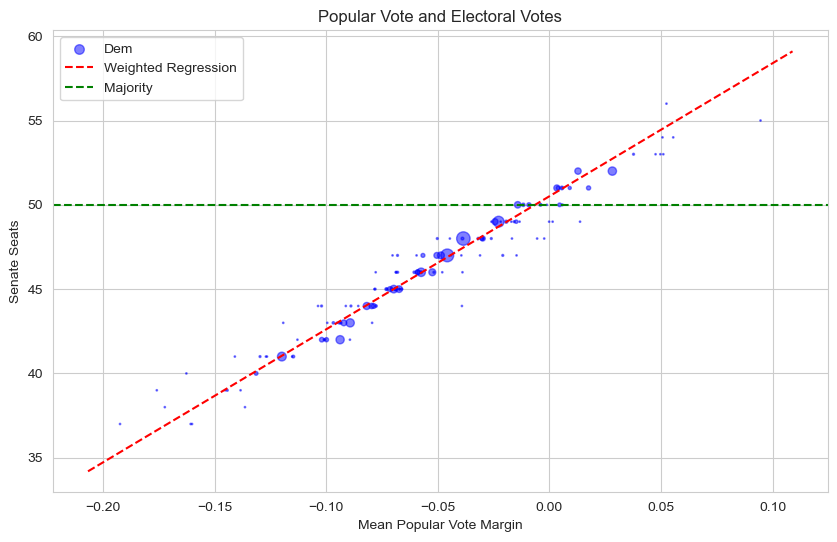

In [349]:
# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(grouped_df['generic_margin'], grouped_df['dem'], 
            s=grouped_df['count'], color='blue', alpha=0.5, label='Dem')

# Perform weighted linear regression using 'Count' as the weight
X = grouped_df['generic_margin']
y = grouped_df['dem']
weights = grouped_df['count']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Perform weighted least squares regression
wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

# Extract regression line parameters
slope = results.params[1]
intercept = results.params[0]

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

plt.axhline(y=50, color='green', linestyle='--', label='Majority')

# Add labels and title
plt.xlabel('Mean Popular Vote Margin')
plt.ylabel('Senate Seats')
plt.title('Popular Vote and Electoral Votes')

# Add legend
plt.legend()

# Show plot
plt.show()

In [350]:
df_2022 = pd.read_csv("../Data/clean/2022_senate_results.csv")

In [351]:
df_margin = pd.merge(df_margin, df_2022[['State','margin']],
         how="left",
         left_on='state_code',
         right_on='State').drop(columns='state_code')

df_margin['error'] =  df_margin.hdi_mean - df_margin.margin

df_margin = pd.merge(df_margin, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='State',
         right_index=True)

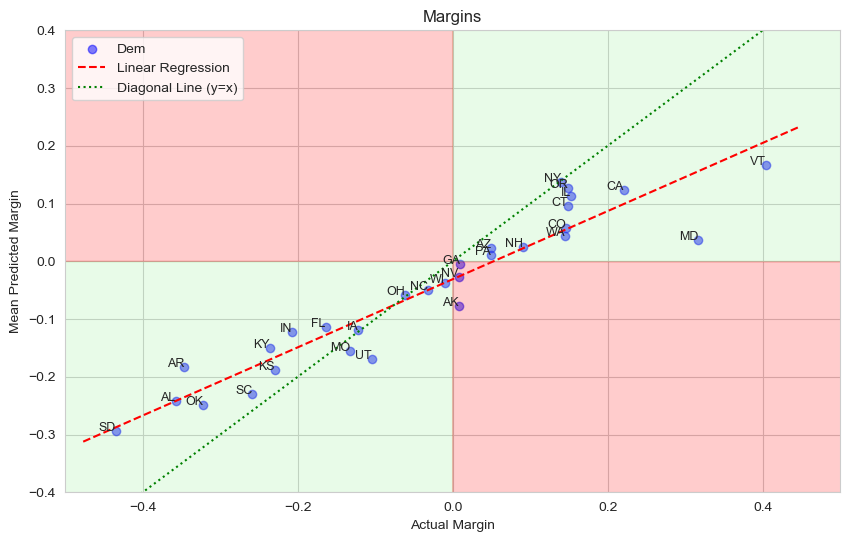

In [352]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_margin['margin'], df_margin['hdi_mean'])

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Linear Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle=':', label='Diagonal Line (y=x)')

ax.set_xlim(-.5, .5)
ax.set_ylim(-.4, .4)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

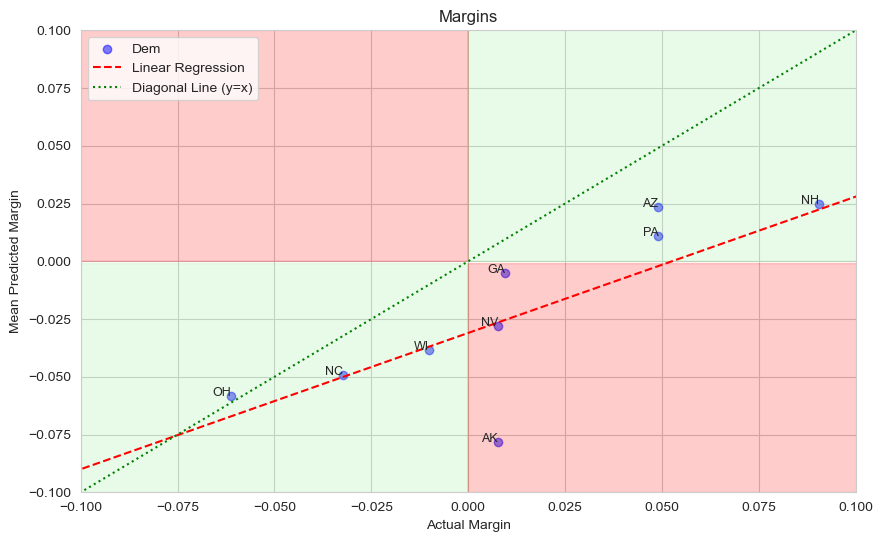

In [353]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_margin['margin'], df_margin['hdi_mean'])

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Linear Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle=':', label='Diagonal Line (y=x)')

ax.set_xlim(-.1, .1)
ax.set_ylim(-.1, .1)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

In [354]:
calc_slope = 1/slope
calc_intercept = intercept

In [355]:
calc_intercept

-0.031005562177505226

In [356]:
intercept

-0.031005562177505226

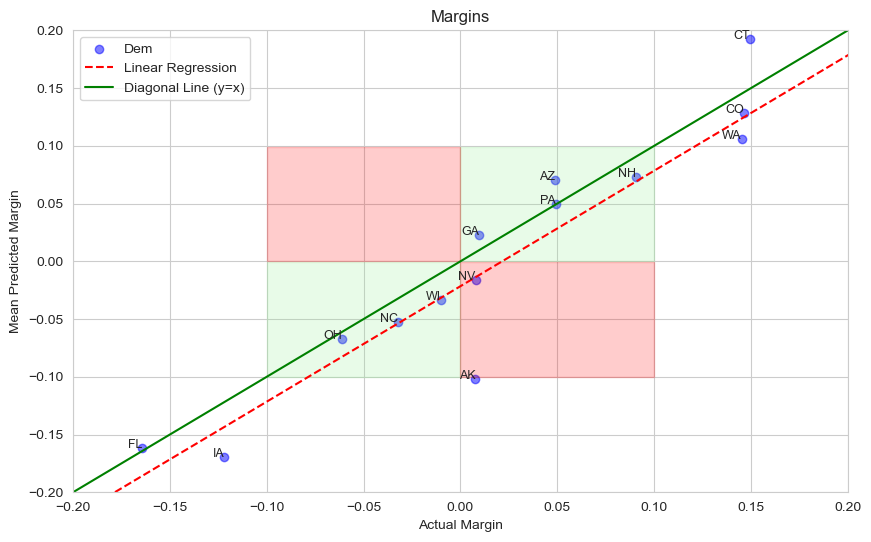

In [364]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], (df_margin['hdi_mean']*calc_slope-calc_intercept), 
            color='blue', alpha=0.5, label='Dem')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_margin['margin'], (df_margin['hdi_mean']*calc_slope-calc_intercept))

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Linear Regression')

# Add diagonal line (y = x)
plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)

# Shade the quadrants
ax.fill_betweenx(y=np.arange(0, 0.1, 0.001), x1=0, x2=0.1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-0.1, 0, 0.001), x1=-0.1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 0.1, 0.001), x1=-0.1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-0.1, 0, 0.001), x1=0, x2=0.1, color='red', alpha=0.2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = (df_margin['hdi_mean']*calc_slope-calc_intercept)[i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], (df_margin['hdi_mean']*calc_slope-calc_intercept)[i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

# Add legend
plt.legend()

# Show plot
plt.show()

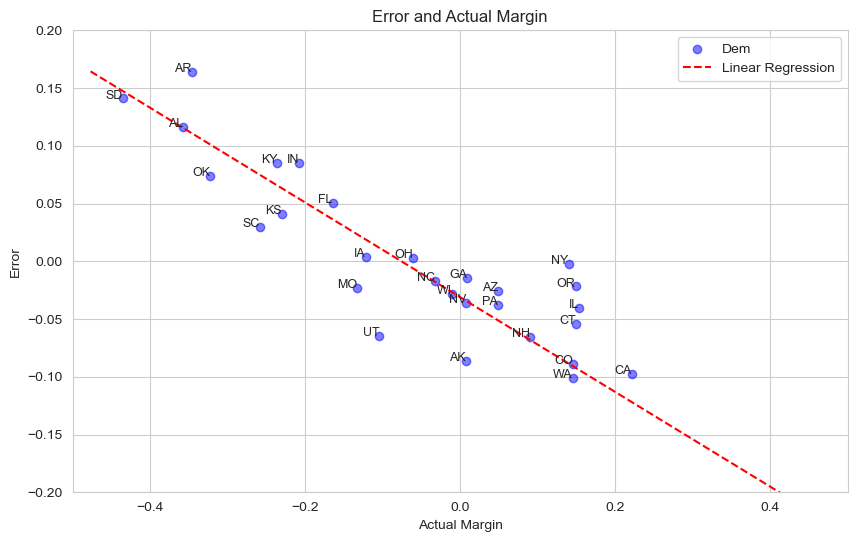

In [358]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error'], 
            color='blue', alpha=0.5, label='Dem')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_margin['margin'], df_margin['error'])

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Linear Regression')

#ax.set_xlim(-.5, .9)
#ax.set_ylim(-.15, .15)

ax.set_xlim(-.5, .5)
ax.set_ylim(-.2, .2)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()

In [359]:
slope

-0.41000143444247233

In [360]:
df_margin['mean_corrected'] = df_margin.hdi_mean*calc_slope-calc_intercept
df_margin['error_corrected'] =  df_margin.mean_corrected - df_margin.margin

In [361]:
df_margin

,hdi_03,hdi_25,hdi_mean,hdi_75,hdi_97,electoral_2024,State,margin,error,count,mean_corrected,error_corrected
0,-0.060794,-0.005317,0.023321,0.053295,0.107712,10,AZ,0.0489,-0.025579,66,0.070532,0.021632
1,-0.108968,-0.056819,-0.027902,0.002473,0.054826,10,NV,0.0078,-0.035702,52,-0.016286,-0.024086
2,-0.078605,-0.030175,-0.004875,0.020796,0.064467,10,GA,0.0096,-0.014475,76,0.022743,0.013143
3,-0.123831,-0.064472,-0.038229,-0.009593,0.036967,10,WI,-0.0101,-0.028129,35,-0.033789,-0.023689
4,-0.144150,-0.089034,-0.058147,-0.028157,0.030503,10,OH,-0.0611,0.002953,58,-0.067548,-0.006448
5,-0.210147,-0.152490,-0.122217,-0.090870,-0.033237,10,IN,-0.2075,0.085283,3,-0.176142,0.031358
6,-0.257224,-0.189976,-0.155628,-0.121249,-0.056973,10,MO,-0.1326,-0.023028,13,-0.232771,-0.100171
7,-0.029681,0.029900,0.057605,0.087569,0.139323,10,CO,0.1462,-0.088595,21,0.128641,-0.017559
8,-0.056408,-0.004776,0.024732,0.053015,0.105187,10,NH,0.0906,-0.065868,33,0.072924,-0.017676
9,-0.333193,-0.275010,-0.248086,-0.220880,-0.168096,10,OK,-0.3220,0.073914,11,-0.389481,-0.067481


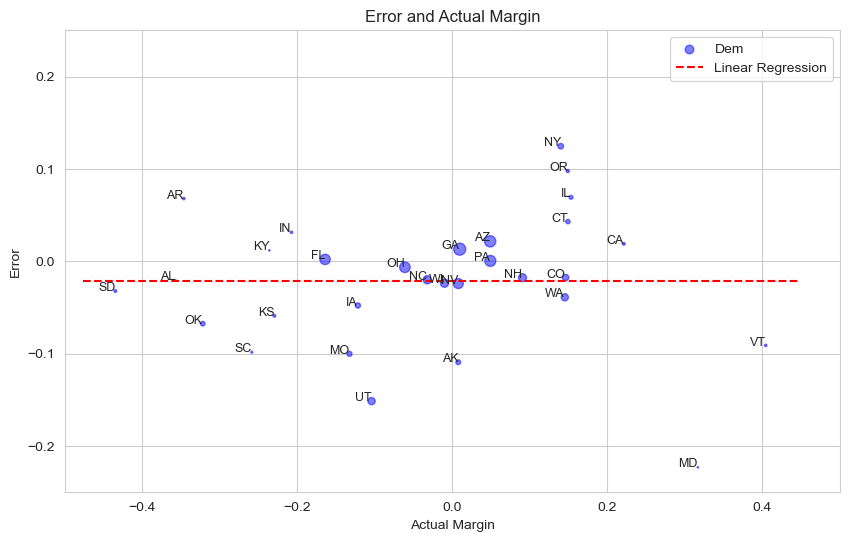

In [362]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 'dem' on the y-axis
plt.scatter(df_margin['margin'], df_margin['error_corrected'], 
            s=df_margin['count'],color='blue', alpha=0.5, label='Dem')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_margin['margin'], df_margin['error_corrected'])

# Create regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Linear Regression')

ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)

# Get the current x-axis limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add labels from the 'State' column only for points within the limits
for i, state in enumerate(df_margin['State']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error_corrected'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):  # Only label points within the x-axis limits
        plt.text(df_margin['margin'][i], df_margin['error_corrected'][i], state, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

# Add legend
plt.legend()

# Show plot
plt.show()